The first three cells are a copy of the DarkPhoton.py files included in the DarkCapPy package.
I have changed the relative path to the configuration files (constants.py, atomicData.py, etc..), and some of the relative paths within those files so that it would work from this notebook, without having to install the package. I have also changed the parameters in PlanetData.py back to Earth's.

Somehow, the computing time for the kappa_0 function is excessively long when importing the package into jupyter notebook on my end. Running the code directly from the notebook makes computing time acceptable (about 2-3 minutes vs an hour). There might be an issue in multiple imports of the package within the configuration files that needs to be looked at in the original package.

In [1]:
################################################################
# Import Python Libraries
################################################################
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

from Configure.Constants  import *
from Configure.AtomicData import *
from Configure.PlanetData  import *
from Configure.Conversions import amu2GeV

# Capture rate computation without darkphoton

Here we will tweak the DarkCapPy code to compute the capture rate assuming a constant cross-section for the $\chi$-SM scattering.

$\sigma_{SI} = 10^{-42} cm^2$


### First attempt

We simply replace the integral over recoil energy by that constant value. Therefore, we do not need the kappa_0 function, as there is no dependency in $m_A$ nor in $\varepsilon$ left in the capture rate calculation.

Therefore the capture rate for each element can be written as :


\begin{equation}
    C_{Cap}^N = n_\chi\sigma_{SI}\int_0^{R_\oplus}dr4\pi r^2n_N(r)\int_0^{v_{gal}}du4\pi u^2f_\oplus(u)\frac{u^2 + v_\oplus^2(r)}{u}
\end{equation}

And the total capture rate would be written as :

\begin{equation}
    C_{Cap} = \sum_NC_{Cap}^N
\end{equation}


$v_\oplus(r)$ is the escape velocity at radius r.
We know that the escape velocity at a distance r off the earth is given by $\sqrt{\frac{2GM_\oplus}{r}}$, where G is the gravitationnal constant, and $M_\oplus$ is the mass of the Earth.

As we are looking into the escape velocity within the Earth (ie at $r<R_\oplus$), we need to evaluate the escape velocity considering the enclosed mass at distance r from the center of mass. The escape velocity is therefore given by $\sqrt{\frac{2GM(r)}{r}}$. Using the enclosedMass_List from DarkCapPy package, we can compute the escape velocity as a function of r

There already is a list containing the square value of the escape velocity, expressed in natural units, in the DarkCapPy package so that we don't need to calculate it. It is the escVel2_List. 

In this first try, we'll just integrate over all possible values for velocity, from 0 to the minimum value between $v_{gal}$ and $u_{int}$

In [110]:

# import os                                          | Reference: https://stackoverflow.com/questions/779495/python-access-data-in-package-subdirectory
# this_dir, this_filename = os.path.split(__file__)  | This was a hack for importing the branching ratio inside of this file. 
# DATA_PATH = os.path.join(this_dir, "brtoe.csv")    | It is not presently needed, but may be useful in the future. 



################################################################
# Capture Rate Functions
################################################################

sigma = 1e-42 # constant cross-section





########################
# Kinematics
########################
def eMin(u, m_X):
	'''
	eMin(u, m_X)

	Returns the minimum kinetic energy to become Gravitationally captured by Earth

	[m_X] = GeV
	'''

	function = (0.5) * m_X * u**2
#     assert (function >=0), '(u, m_X): (%e,%e) result in a negative eMin' % (u, m_X)
	return function

def eMax(element, m_X, rIndex, u):
	'''
	eMax(element, m_X, rIndex, u)

	Returns the maximum kinetic energy allowed by the kinematics

	[m_X] = GeV

	rIndex specifies the index in the escape velocity array escVel2_List[rIndex]
	'''

	m_N = amu2GeV(atomicNumbers[element])
	mu = m_N*m_X / (m_N + m_X)
	vCross2 = (escVel2_List[rIndex])
	function = 2 * mu**2 * (u**2 + vCross2) / m_N
#     assert (function >= 0), '(element, m_X, rIndex, u): (%s, %e, %i, %e) result in negative eMax' %(element, m_X, rIndex, u)
	return function




########################
# Intersection Velocity
########################
def EminEmaxIntersection(element, m_X, rIndex):
	'''
	EminEmaxIntersection(element, m_X, rIndex):

	Returns the velocity uInt when eMin = eMax.

	[m_X] = GeV

	'''
	m_N = amu2GeV(atomicNumbers[element])
	mu = (m_N*m_X)/(m_N+m_X)

	sqrtvCross2 = np.sqrt(escVel2_List[rIndex])
	# Calculate the intersection uInt of eMin and eMax given a specific rIndex
	A = m_X/2. 
	B = 2. * mu**2 / m_N
	print(m_X, A, B, mu, m_N)
	uInt = np.sqrt( ( B ) / (A-B) ) * sqrtvCross2

	return uInt




########################
# Photon Velocity and Energy Integration
########################
def intDuDEr(element, rIndex, m_X):
	'''
	intDuDER(element, m_X, rIndex):

	Returns the evaluated velocity and recoil energy integrals for dark photon scattering

	[m_X] = GeV
	'''
    
	def integrand(u):
		fu = fCrossInterp(u)
		integrand = sigma * u * fu * (u **2 + escVel2_List[rIndex])

		return integrand

	# Calculate the intersection uInt of eMin and eMax given a specific rIndex
	uInt = EminEmaxIntersection(element, m_X, rIndex)

	uLow = 0
	uHigh = min(uInt, V_gal) # We take the minimal value between the intersection velocity and galactic escape velocity
	integral = integrate.quad(integrand, uLow, uHigh)[0]
	return integral



We'll be evaluating the integral over velocity for all dark matter mass in the mx range, all radi, and all elements, and save it into an npy file

In [111]:
mx = np.logspace(1, 2, 20)

In [123]:
velocityIntegral = np.load('data/NP1_velocityIntegral.npy')

In [115]:

########################
# Sum Over Radii
########################
def sumOverR(element, m_X):
	'''
	sumOverR(element, m_X)

	Returns the summation over radius of the velocity and recoil energy integration

	[m_X] = GeV
	'''

	tempSum = 0
    
	for i in range(0, len(radius_List)):
		r = radius_List[i]
		deltaR = deltaR_List[i]

		n_N = numDensity_Func(element)[i]
		j = np.where(element_List == element)
		k = np.where(mx == m_X)
		summand = n_N * r**2 * velocityIntegral[i, j, k] * deltaR 
		tempSum += summand
	return tempSum



In [124]:
sumOverRadi = pd.read_csv('data/NP1sumOverRadi', index_col = 0)
sumOverRadi

,O16,Na,Mg,Al,Si,P,S,Ca,Cr,Fe,Ni
0,0.414959,0.000158,0.010467,0.000586,0.005438,0.000027,0.000184,0.000124,0.000020,0.001248,0.000062
1,1.632302,0.000298,0.019033,0.000974,0.008825,0.000041,0.000278,0.000172,0.000027,0.001608,0.000080
2,13.462727,0.000653,0.039351,0.001776,0.015600,0.000070,0.000448,0.000250,0.000036,0.002120,0.000104
3,418.156458,0.001783,0.098222,0.003688,0.030998,0.000129,0.000785,0.000381,0.000050,0.002875,0.000139
4,158.554732,0.007031,0.331794,0.009267,0.072889,0.000273,0.001537,0.000621,0.000071,0.004034,0.000192
5,6.408989,0.058339,1.972507,0.031655,0.222848,0.000705,0.003537,0.001104,0.000108,0.005908,0.000276
6,1.033733,1.788781,44.282433,0.192567,1.085799,0.002532,0.010433,0.002211,0.000173,0.009132,0.000417
7,0.299857,0.661515,144.999464,4.562530,14.787887,0.016954,0.047371,0.005263,0.000303,0.015139,0.000669
8,0.118707,0.027017,5.359905,13.284551,130.028211,0.400290,0.531814,0.016418,0.000593,0.027538,0.001164
9,0.056968,0.004378,0.613497,0.453717,12.038031,0.491420,4.429260,0.083230,0.001364,0.056957,0.002266


In [126]:
def singleElementCap(element, m_X):
	'''
	singleElementCap(element, m_X)

	Returns the capture rate due to a single element for the specified parameters

	[m_X] = GeV
	'''
	n_X = 0.3/m_X # GeV/cm^3

	conversion = (5.06e13)**-3 * (1.52e24) # Conversion to seconds (cm^-3)(GeV^-2) -> (s^-1)
	prefactors = (4*np.pi)**2
	function = n_X * conversion * prefactors * sumOverRadi[element][np.where(mx == m_X)[0]]
	return function

In [127]:
########################
# Full Capture Rate
########################
def cCap(m_X):
	'''
	cCap(m_X, m_A, epsilon, alpha, alpha_X)

	returns the full capture rate in sec^-1 for the specified parameters

	Note: This function is the less efficient way to perform this calculation. Every point in (m_A, epsilon) space 
		involves peforming the full tripple integral over recoil energy, incident DM velocity, and Earth radius
		which is time consuming.

	[m_X] = GeV
	'''
	totalCap = 0
	for element in element_List:
		elementCap = singleElementCap(element, m_X)
		print ('Element:', element,',' 'Cap: ', elementCap)
		totalCap += elementCap 
	return totalCap


In [128]:
capNoPhoton = np.empty_like(mx)

In [129]:
for i, m in enumerate(mx) :
    capNoPhoton[i] = cCap(m)


Element: O16 ,Cap:  0    2.306421e-17
Name: O16, dtype: float64
Element: Na ,Cap:  0    8.762717e-21
Name: Na, dtype: float64
Element: Mg ,Cap:  0    5.817956e-19
Name: Mg, dtype: float64
Element: Al ,Cap:  0    3.259119e-20
Name: Al, dtype: float64
Element: Si ,Cap:  0    3.022500e-19
Name: Si, dtype: float64
Element: P ,Cap:  0    1.476964e-21
Name: P, dtype: float64
Element: S ,Cap:  0    1.023863e-20
Name: S, dtype: float64
Element: Ca ,Cap:  0    6.878808e-21
Name: Ca, dtype: float64
Element: Cr ,Cap:  0    1.136212e-21
Name: Cr, dtype: float64
Element: Fe ,Cap:  0    6.936592e-20
Name: Fe, dtype: float64
Element: Ni ,Cap:  0    3.468870e-21
Name: Ni, dtype: float64
Element: O16 ,Cap:  1    8.037147e-17
Name: O16, dtype: float64
Element: Na ,Cap:  1    1.469302e-20
Name: Na, dtype: float64
Element: Mg ,Cap:  1    9.371525e-19
Name: Mg, dtype: float64
Element: Al ,Cap:  1    4.795230e-20
Name: Al, dtype: float64
Element: Si ,Cap:  1    4.345073e-19
Name: Si, dtype: float64
Element:

Element: Ca ,Cap:  13    6.859186e-19
Name: Ca, dtype: float64
Element: Cr ,Cap:  13    2.322576e-17
Name: Cr, dtype: float64
Element: Fe ,Cap:  13    6.509118e-16
Name: Fe, dtype: float64
Element: Ni ,Cap:  13    8.042841e-18
Name: Ni, dtype: float64
Element: O16 ,Cap:  14    5.964878e-20
Name: O16, dtype: float64
Element: Na ,Cap:  14    8.122783e-22
Name: Na, dtype: float64
Element: Mg ,Cap:  14    7.788443e-20
Name: Mg, dtype: float64
Element: Al ,Cap:  14    1.202871e-20
Name: Al, dtype: float64
Element: Si ,Cap:  14    1.531914e-19
Name: Si, dtype: float64
Element: P ,Cap:  14    1.383540e-21
Name: P, dtype: float64
Element: S ,Cap:  14    1.745619e-20
Name: S, dtype: float64
Element: Ca ,Cap:  14    1.337886e-19
Name: Ca, dtype: float64
Element: Cr ,Cap:  14    3.544990e-18
Name: Cr, dtype: float64
Element: Fe ,Cap:  14    1.302959e-15
Name: Fe, dtype: float64
Element: Ni ,Cap:  14    7.034629e-17
Name: Ni, dtype: float64
Element: O16 ,Cap:  15    3.891820e-20
Name: O16, dtype: 

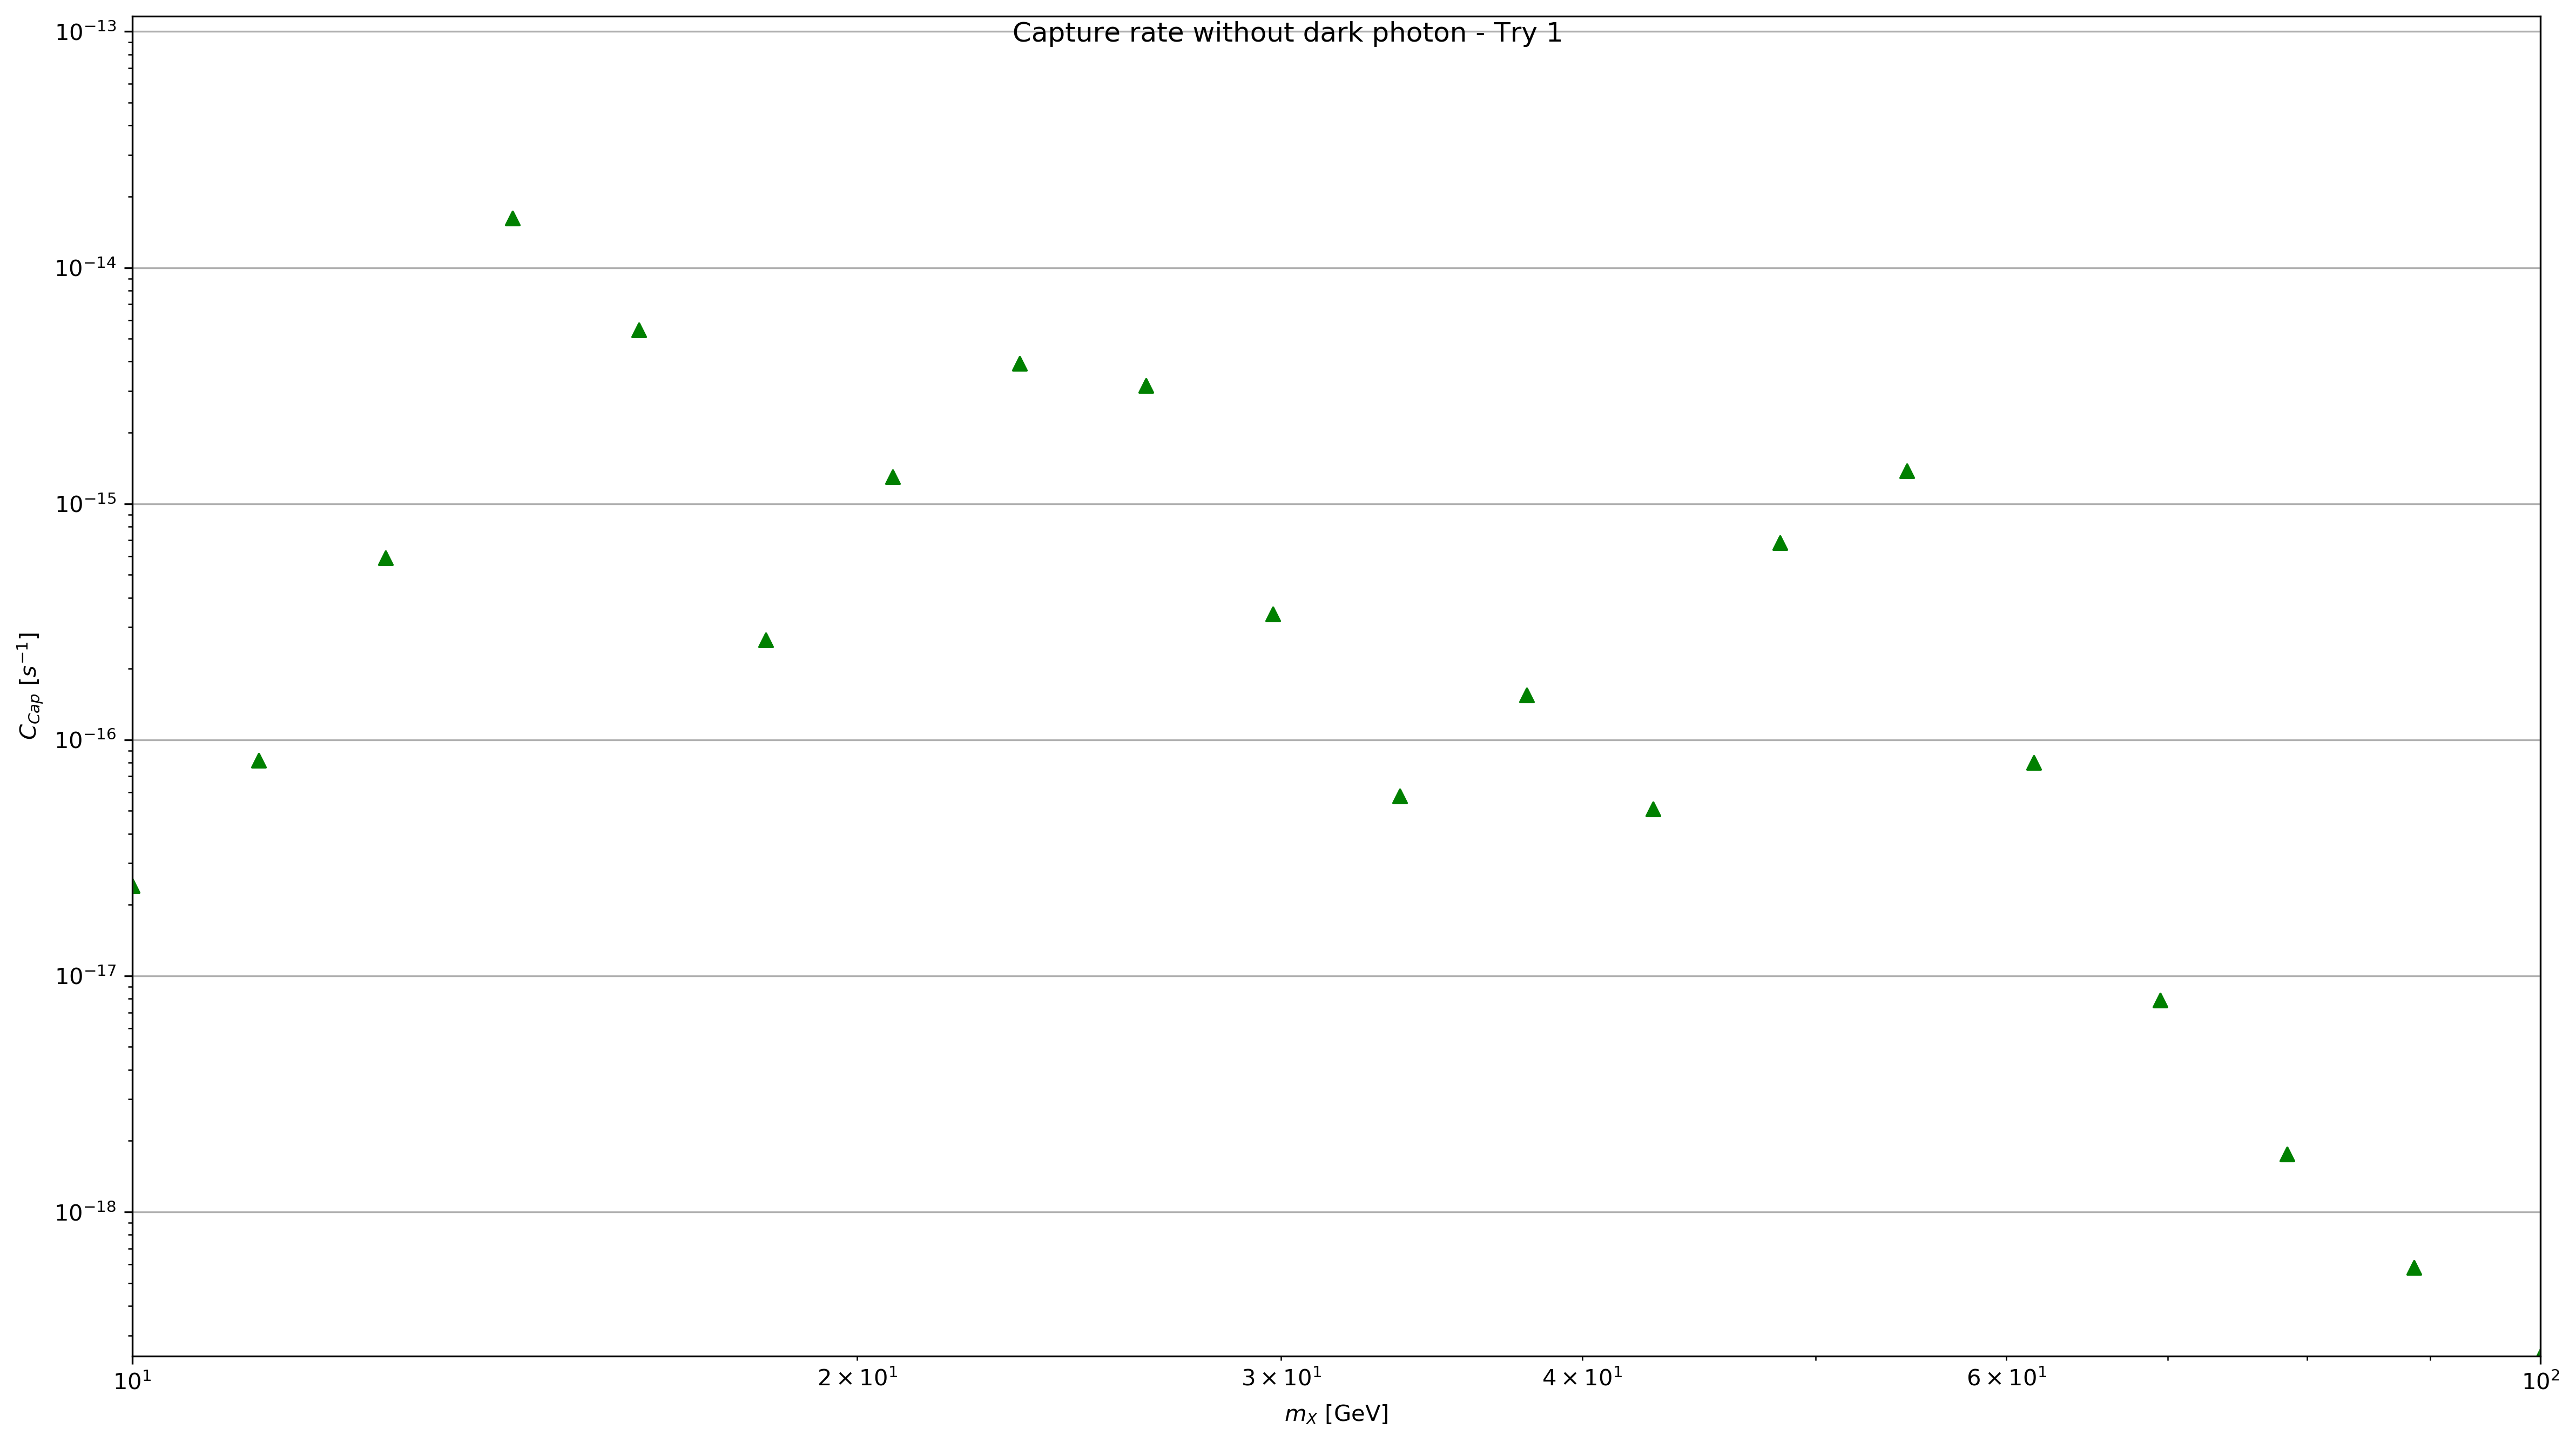

In [132]:
fig, ax = plt.subplots(1, 1, figsize = (16, 9), dpi = 300)

ax.scatter(mx, capNoPhoton, marker = '^', color = 'g')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10, 100)
ax.set_ylim(np.amin(capNoPhoton), np.amax(capNoPhoton)+ 1e-13)
ax.grid()

ax.set_ylabel('$C_{Cap}$ [$s^{-1}$]')
ax.set_xlabel('$m_X$ [GeV]')

fig.suptitle("Capture rate without dark photon - Try 1")
fig.tight_layout()

In [133]:
fig.savefig("data/Capture_rate_NP1")